In [21]:
from IPython.display import display_html
display_html("""<button onclick="$('.input, .prompt, .output_stderr, .output_error').toggle();">Toggle Code</button>""", raw=True)

Toggle Code

In [22]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 构建期权收益计算需要的class

基本操作class, 买或者卖

In [23]:
class Operation(Enum):
    buy = 0
    sell = 1

期权主class

In [24]:
class Option(object):
    def __init__(self,
                 operation: Operation=None,
                 option_price: float=None,
                 strike_price: float=None,
                 multiplier: int=None,
                 number: int=None):
        self.operation = operation
        self.option_price = option_price
        self.strike_price = strike_price
        self.multiplier = multiplier
        self.number = number

看涨期权

In [25]:
class Call(Option):
    pass

看跌期权

In [26]:
class Put(Option):
    pass

标的物直接买卖，这里以stock为例

In [27]:
class Stock(object):
    def __init__(self,
                 operation: Operation=None,
                 stock_price: float=None,
                 number: int=None):
        self.operation = operation
        self.stock_price = stock_price
        self.number = number

收益计算器。给定标的物实际价格 actual price以及建仓的call, put, stock，计算以此价格清仓的收益。

In [28]:
class GainCalculation(object):
    def __init__(self):
        self.gain: float = None
    def __call__(self,
                 actual_price: float,
                 call_list: list = [],
                 put_list: list = [],
                 stock_list: list = [],
                 *args,
                 **kwargs):
        self.call_list = call_list
        self.put_list = put_list
        self.stock_list= stock_list
        self.actual_price = actual_price
        self.gain = 0.0
        for call in self.call_list:
            if call.operation == Operation.buy: 
                 self._process_buy_call(call)
            else:
                 self._process_sell_call(call)

        for put in self.put_list:
            if put.operation == Operation.buy: 
                 self._process_buy_put(put)
            else:
                 self._process_sell_put(put)

        for stock in self.stock_list:
            if stock.operation == Operation.buy: 
                 self._process_buy_stock(stock)
            else:
                 self._process_sell_stock(stock)

    def _process_buy_call(self, call: Call):
        if self.actual_price > call.strike_price:
            price_diff: float = self.actual_price - call.strike_price
            # the value gained by executing option
            self.gain = self.gain + price_diff * call.multiplier * call.number
            # the value lost by option price
            self.gain = self.gain - call.option_price * call.number * call.multiplier
        else:
            # the value lost by option price
            self.gain = self.gain - call.option_price * call.number * call.multiplier
    def _process_sell_call(self, call: Call):
        if self.actual_price > call.strike_price:
            price_diff: float = self.actual_price - call.strike_price
            # the value lost by buyer executing option
            self.gain = self.gain - price_diff * call.multiplier * call.number
            # the value gain by option price
            self.gain = self.gain + call.option_price * call.number * call.multiplier
        else:
            # the value gain by option price
            self.gain = self.gain + call.option_price * call.number * call.multiplier
            
    def _process_buy_put(self, put: Put):
        if self.actual_price < put.strike_price:
            price_diff: float = put.strike_price - self.actual_price
            # the value gained by executing option
            self.gain = self.gain + price_diff * put.multiplier * put.number
            # the value lost by option price
            self.gain = self.gain - put.option_price * put.number * put.multiplier
        else:
            # the value lost by option price
            self.gain = self.gain - put.option_price * put.number * put.multiplier

    def _process_sell_put(self, put: Put):
        if self.actual_price < put.strike_price:
            price_diff: float = put.strike_price - self.actual_price
            # the value gained by executing option
            self.gain = self.gain - price_diff * put.multiplier * put.number
            # the value lost by option price
            self.gain = self.gain + put.option_price * put.number * put.multiplier
        else:
            # the value lost by option price
            self.gain = self.gain + put.option_price * put.number * put.multiplier

    def _process_buy_stock(self, stock: Stock):
        price_diff: float = self.actual_price - stock.stock_price
        # the value gained by selling stock
        self.gain = self.gain + price_diff * stock.number

    def _process_sell_stock(self, stock: Stock):
        price_diff: float = stock.stock_price - self.actual_price
        # the value gained by buy back stock
        self.gain = self.gain + price_diff * stock.number

收益分布作图函数

In [29]:
def plot_gain_distribution(actual_price_start,
                           actual_price_stop,
                           step: int,
                           call_list: list=[],
                           put_list: list=[],
                           stock_list: list=[]):
    actual_price_array = np.arange(actual_price_start,actual_price_stop,step)
    gain_list = []

    for actual_price in actual_price_array:
        gain_calculate = GainCalculation()
        gain_calculate(call_list=call_list,
                       put_list=put_list,
                       stock_list=stock_list,
                       actual_price=actual_price)
        gain_list.append(gain_calculate.gain)

    _ = plt.plot(actual_price_array, gain_list)
    _ = plt.plot([-10000,10000],[0,0])
    _ = plt.xlim(actual_price_start,actual_price_stop)
    _ = plt.grid()
    _ = plt.xlabel('actual price')
    _ = plt.ylabel('strategy gain')

# 1.备兑看涨期权

基本概念： 买入一定标的，再卖出一张看涨期权

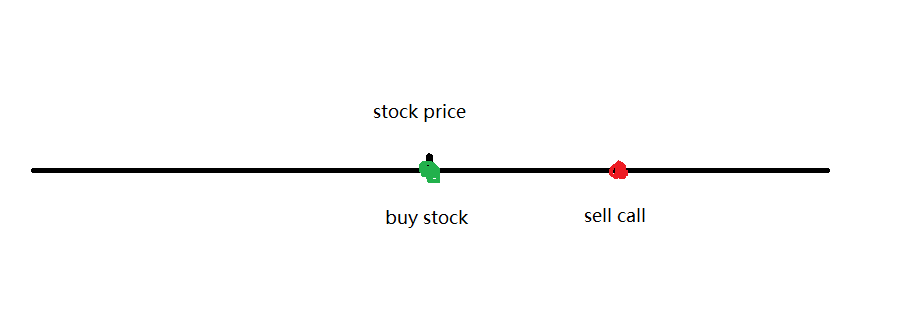

例： 当前股价100美元，买100股， 卖105美元看涨期权收入权利金100美元

In [49]:
call_1 = Call(operation=Operation.sell,
              option_price=1,
              strike_price=105,
              multiplier=100,
              number=1)

stock_1 = Stock(operation=Operation.buy,
                stock_price=100,
                number=100)

策略收益分布统计

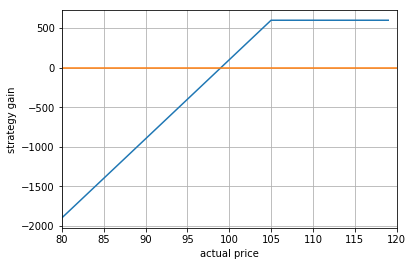

In [40]:
plot_gain_distribution(actual_price_start=80,
                       actual_price_stop=120,
                       step=1,
                       call_list=[call_1],
                       put_list=[],
                       stock_list=[stock_1])

实际效果就是下方多了一点保险， 上方收益有上限，但是到达上限之前 多了一点点

以下是**只买stock不买call**的收益统计曲线，作为上面的对比参考。

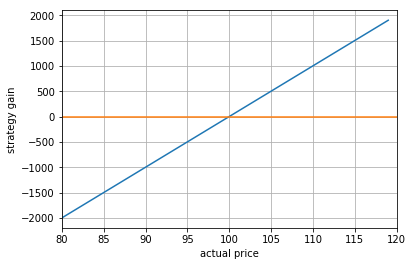

In [42]:
plot_gain_distribution(actual_price_start=80,
                       actual_price_stop=120,
                       step=1,
                       call_list=[],
                       put_list=[],
                       stock_list=[stock_1])

# 2. 保护性看跌期权

买入股票后，再买入一张看跌期权

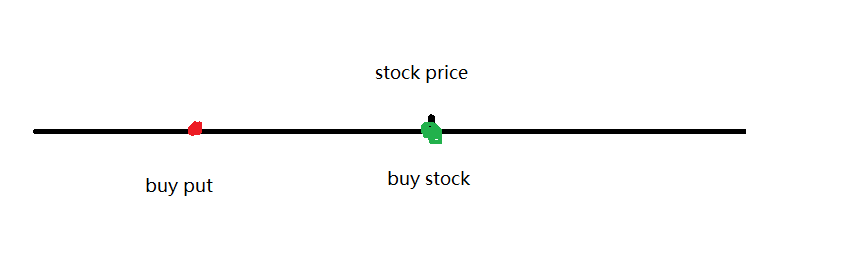

例： 当前股价100美元，买100股， 买100美元看跌期权支出权利金100美元

In [50]:
put_1 = Put(operation=Operation.buy,
              option_price=1,
              strike_price=100,
              multiplier=100,
              number=1)

stock_1 = Stock(operation=Operation.buy,
                stock_price=100,
                number=100)

策略收益分布统计

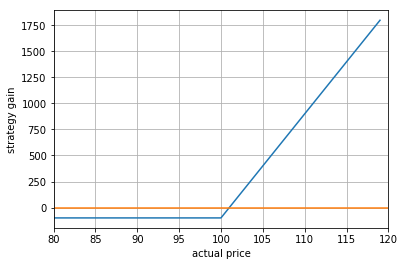

In [46]:
plot_gain_distribution(actual_price_start=80,
                       actual_price_stop=120,
                       step=1,
                       call_list=[],
                       put_list=[put_1],
                       stock_list=[stock_1])

实际效果就是下方相当于加了一个加保险的超级止损， 上方收益无上限，但是牺牲期权费的收益

以下是**只买stock不买put**的收益统计曲线，作为上面的对比参考。

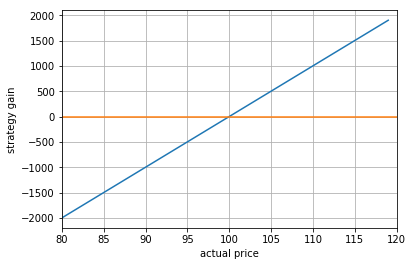

In [48]:
plot_gain_distribution(actual_price_start=80,
                       actual_price_stop=120,
                       step=1,
                       call_list=[],
                       put_list=[],
                       stock_list=[stock_1])

# 3. 垂直价差策略

策略思想： 同时买卖2个看涨（或者看跌）期权<br>
作用：做多或做空股价的一部分变化范围

## 3.1 两个看涨期权 买近卖远(借方看涨价差)

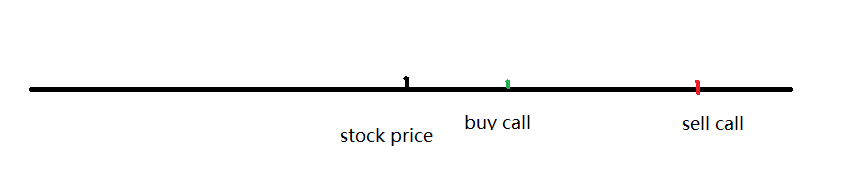

In [61]:
call_1 = Call(operation=Operation.buy,
              option_price=2,
              strike_price=105,
              multiplier=100,
              number=1)

call_2 = Call(operation=Operation.sell,
              option_price=0.5,
              strike_price=110,
              multiplier=100,
              number=1)

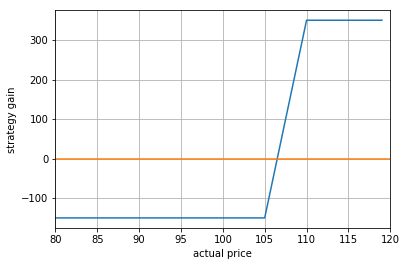

In [67]:
plot_gain_distribution(actual_price_start=80,
                       actual_price_stop=120,
                       step=1,
                       call_list=[call_1, call_2],
                       put_list=[],
                       stock_list=[])

牛市用比较好

## 3.2 两个看涨期权 买远卖近(贷方看涨价差)

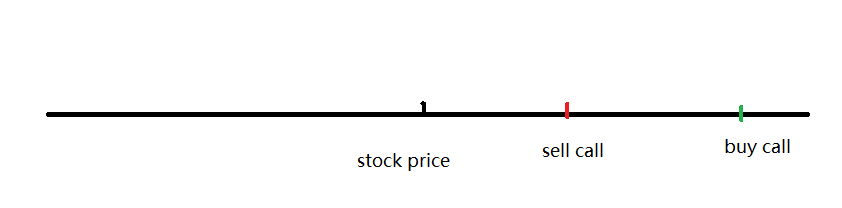

In [68]:
call_1 = Call(operation=Operation.sell,
              option_price=2,
              strike_price=105,
              multiplier=100,
              number=1)

call_2 = Call(operation=Operation.buy,
              option_price=0.5,
              strike_price=110,
              multiplier=100,
              number=1)

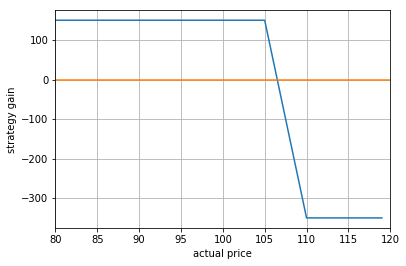

In [69]:
plot_gain_distribution(actual_price_start=80,
                       actual_price_stop=120,
                       step=1,
                       call_list=[call_1, call_2],
                       put_list=[],
                       stock_list=[])

熊市使用比较好，赚期权费

## 3.3 两个看跌期权 买近卖远(借方看跌价差)

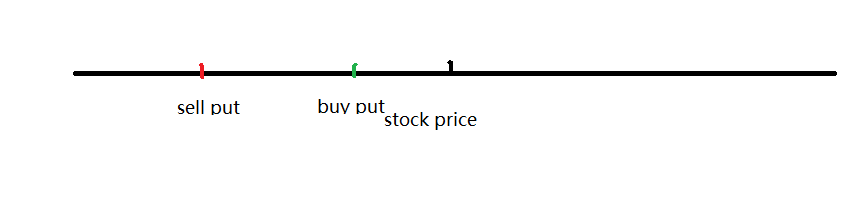

In [71]:
put_1 = Put(operation=Operation.buy,
              option_price=2,
              strike_price=95,
              multiplier=100,
              number=1)

put_2 = Put(operation=Operation.sell,
              option_price=0.5,
              strike_price=90,
              multiplier=100,
              number=1)

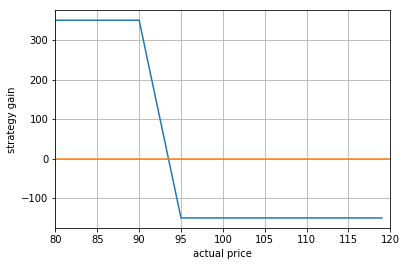

In [72]:
plot_gain_distribution(actual_price_start=80,
                       actual_price_stop=120,
                       step=1,
                       call_list=[],
                       put_list=[put_1, put_2],
                       stock_list=[])

熊市用比较好

## 3.4 两个看跌期权 买远卖近(贷方看跌价差)

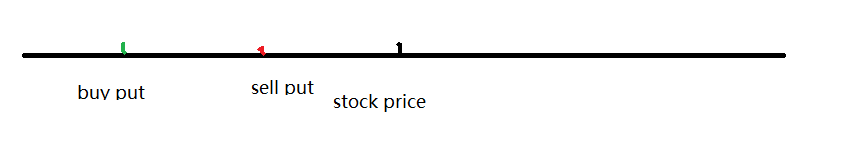

In [73]:
put_1 = Put(operation=Operation.sell,
              option_price=2,
              strike_price=95,
              multiplier=100,
              number=1)

put_2 = Put(operation=Operation.buy,
              option_price=0.5,
              strike_price=90,
              multiplier=100,
              number=1)

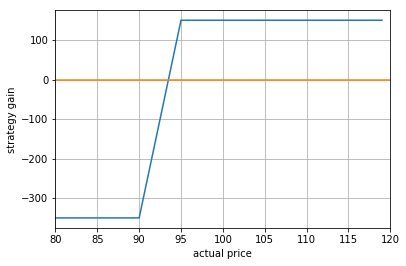

In [74]:
plot_gain_distribution(actual_price_start=80,
                       actual_price_stop=120,
                       step=1,
                       call_list=[],
                       put_list=[put_1, put_2],
                       stock_list=[])

牛市使用比较好，赚期权费

# 4. 跨式组合策略

策略：同时买入1个看涨和1个看跌(都是虚值)<br>
策略思想，对冲delta,纯押注波动率。
两个行权价的选取即为两个押注的价格区间。

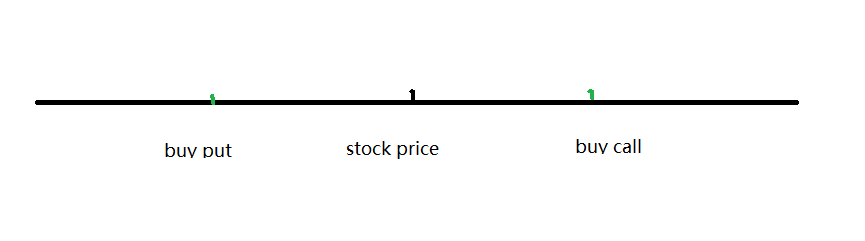

Put call价格可以不对称，称为宽跨式组合。 其目的是使组合delta不为0。

## 4.1 普通跨式组合（两边对称）

两边都买：做多vega,即做多波动率

In [93]:
call_1 = Call(operation=Operation.buy,
              option_price=2,
              strike_price=105,
              multiplier=100,
              number=1)

put_1 = Put(operation=Operation.buy,
              option_price=2,
              strike_price=95,
              multiplier=100,
              number=1)

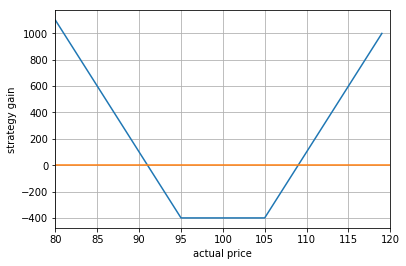

In [94]:
plot_gain_distribution(actual_price_start=80,
                       actual_price_stop=120,
                       step=1,
                       call_list=[call_1],
                       put_list=[put_1],
                       stock_list=[])

两边都卖：做空vega,即做空波动率

In [95]:
call_1 = Call(operation=Operation.sell,
              option_price=2,
              strike_price=105,
              multiplier=100,
              number=1)

put_1 = Put(operation=Operation.sell,
              option_price=2,
              strike_price=95,
              multiplier=100,
              number=1)

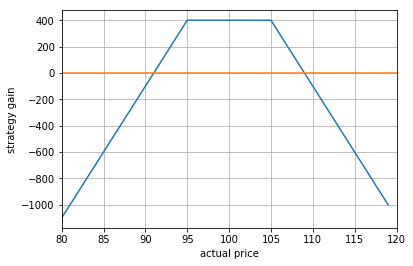

In [96]:
plot_gain_distribution(actual_price_start=80,
                       actual_price_stop=120,
                       step=1,
                       call_list=[call_1],
                       put_list=[put_1],
                       stock_list=[])

## 4.2 宽跨式组合（两边不对称）

对价格波动有一定倾向使用宽跨式

In [99]:
call_1 = Call(operation=Operation.buy,
              option_price=2,
              strike_price=105,
              multiplier=100,
              number=1)

put_1 = Put(operation=Operation.buy,
              option_price=1,
              strike_price=90,
              multiplier=100,
              number=1)

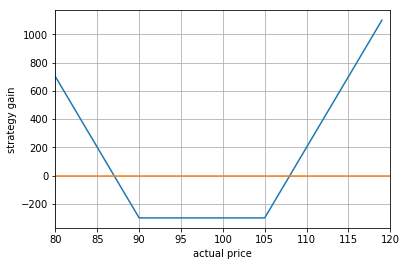

In [100]:
plot_gain_distribution(actual_price_start=80,
                       actual_price_stop=120,
                       step=1,
                       call_list=[call_1],
                       put_list=[put_1],
                       stock_list=[])

# 5. 鹰式策略
策略:买卖两个看涨，买卖两个看跌。
策略思想，押注价格波动的实际范围在指定范围内。
相当于两个垂直价差两边合并。

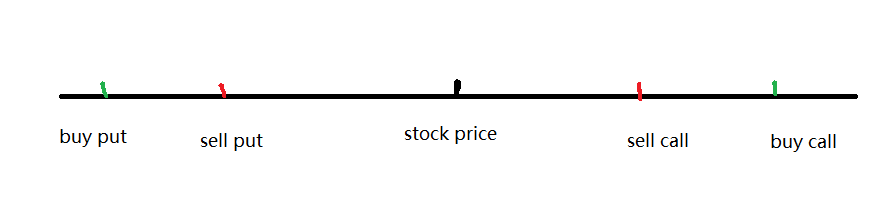

例子如下， 现价2700， 购买以下的期权组合

In [30]:
call_1 = Call(operation=Operation.buy,
              option_price=8.25,
              strike_price=2410,
              multiplier=50,
              number=1)

call_2 = Call(operation=Operation.sell,
              option_price=11.75,
              strike_price=2400,
              multiplier=50,
              number=1)

put_1 = Put(operation=Operation.buy,
            option_price=13.75,
            strike_price=2345,
            multiplier=50,
            number=1)

put_2 = Put(operation=Operation.sell,
            option_price=15.75,
            strike_price=2355,
            multiplier=50,
            number=1)

In [31]:
gain_calculate = GainCalculation()

## 计算标的价格2400收益

In [32]:
gain_calculate(call_list=[call_1, call_2],
                put_list=[put_1, put_2],
                actual_price=2400)

In [33]:
gain_calculate.gain

275.0

## 计算标的价格2500收益

In [34]:
gain_calculate(call_list=[call_1, call_2],
                put_list=[put_1, put_2],
                actual_price=2500)

In [35]:
gain_calculate.gain

-225.0

## 计算标的价格2300收益

In [36]:
gain_calculate(call_list=[call_1, call_2],
               put_list=[put_1, put_2],
               actual_price=2300)

In [37]:
gain_calculate.gain

-225.0

## 收益分布统计

对2300 到 2500 价格区间以1为间隔进行计算

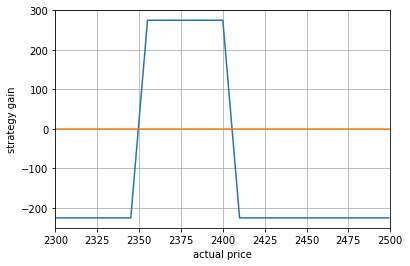

In [38]:
plot_gain_distribution(actual_price_start=2300,
                       actual_price_stop=2500,
                       step=1,
                       call_list=[call_1, call_2],
                       put_list=[put_1, put_2],
                       stock_list=[])

图形显示期权组合相当于押注标的价格在2345 和 2410 之间